<a href="https://colab.research.google.com/github/rutuja-patil24/CMPE-258-Deep_Learning/blob/main/Assignment_04/B)_TensorFlow_From_Scratch_Using_Einsum.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##STEP 1: Import Libraries



In [15]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import plotly.express as px
import pandas as pd

# Set random seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)


## STEP 2: Generate 3-Variable Synthetic Data

In [16]:
def generate_data(num_samples=1000):
    x1 = np.random.uniform(-5, 5, num_samples)
    x2 = np.random.uniform(-5, 5, num_samples)
    x3 = np.random.uniform(-5, 5, num_samples)
    y = np.sin(x1) + np.cos(x2) + 0.5 * x3**2
    y = (y - y.min()) / (y.max() - y.min())  # Normalize

    X = np.vstack([x1, x2, x3]).T.astype(np.float32)
    y = y.astype(np.float32).reshape(-1, 1)

    return X, y

X_np, y_np = generate_data()
X = tf.constant(X_np)
y = tf.constant(y_np)


##STEP 3: Visualize in 4D

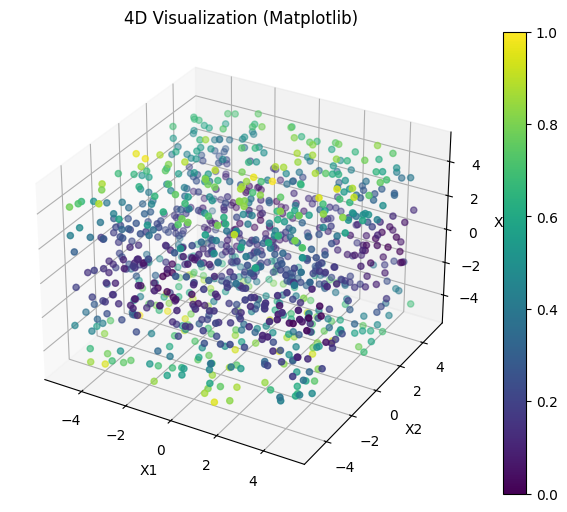

In [17]:
def plot_4d_matplotlib(X, y):
    fig = plt.figure(figsize=(8, 6))
    ax = fig.add_subplot(111, projection='3d')
    sc = ax.scatter(X[:, 0], X[:, 1], X[:, 2], c=y[:, 0], cmap='viridis')
    plt.colorbar(sc)
    ax.set_xlabel('X1')
    ax.set_ylabel('X2')
    ax.set_zlabel('X3')
    plt.title('4D Visualization (Matplotlib)')
    plt.show()

plot_4d_matplotlib(X_np, y_np)


In [18]:
def plot_4d_plotly(X, y):
    df = pd.DataFrame(X, columns=['X1', 'X2', 'X3'])
    df['y'] = y
    fig = px.scatter_3d(df, x='X1', y='X2', z='X3', color='y', title='4D Visualization (Plotly)')
    fig.show()

plot_4d_plotly(X_np, y_np.flatten())


##STEP 4: Initialize Weights (Improved He Initialization)

In [19]:
def he_init(shape):
    return tf.Variable(tf.random.normal(shape, stddev=tf.sqrt(2.0 / shape[1])), dtype=tf.float32)

input_dim = 3
hidden_dim1 = 10
hidden_dim2 = 20  # Increased capacity
output_dim = 1

W1 = he_init((input_dim, hidden_dim1))
b1 = tf.Variable(tf.zeros((1, hidden_dim1)), dtype=tf.float32)
W2 = he_init((hidden_dim1, hidden_dim2))
b2 = tf.Variable(tf.zeros((1, hidden_dim2)), dtype=tf.float32)
W3 = he_init((hidden_dim2, output_dim))
b3 = tf.Variable(tf.zeros((1, output_dim)), dtype=tf.float32)


## STEP 5: Activation Functions

In [20]:
def relu(x):
    return tf.maximum(0.0, x)

def relu_derivative(x):
    return tf.cast(x > 0.0, tf.float32)


##STEP 6: Forward Pass using tf.einsum

In [21]:
def forward_pass(X, W1, b1, W2, b2, W3, b3):
    Z1 = tf.einsum('ij,jk->ik', X, W1) + b1
    A1 = relu(Z1)
    Z2 = tf.einsum('ij,jk->ik', A1, W2) + b2
    A2 = relu(Z2)
    Z3 = tf.einsum('ij,jk->ik', A2, W3) + b3
    return Z3  # No activation in output (regression)


##STEP 7: Training Loop

In [22]:
learning_rate = 0.001
num_epochs = 2000
loss_history = []

for epoch in range(num_epochs):
    with tf.GradientTape() as tape:
        y_pred = forward_pass(X, W1, b1, W2, b2, W3, b3)
        loss = tf.reduce_mean((y_pred - y) ** 2)

    gradients = tape.gradient(loss, [W1, b1, W2, b2, W3, b3])

    for var, grad in zip([W1, b1, W2, b2, W3, b3], gradients):
        var.assign_sub(learning_rate * grad)

    loss_history.append(loss.numpy())

    if epoch % 100 == 0 or epoch < 10:
        print(f"Epoch {epoch}: Loss = {loss.numpy():.5f}")


Epoch 0: Loss = 20.30042
Epoch 1: Loss = 9.81257
Epoch 2: Loss = 6.63519
Epoch 3: Loss = 4.93283
Epoch 4: Loss = 3.91732
Epoch 5: Loss = 3.26796
Epoch 6: Loss = 2.82174
Epoch 7: Loss = 2.49894
Epoch 8: Loss = 2.25349
Epoch 9: Loss = 2.05481
Epoch 100: Loss = 0.26271
Epoch 200: Loss = 0.17084
Epoch 300: Loss = 0.13198
Epoch 400: Loss = 0.10856
Epoch 500: Loss = 0.09221
Epoch 600: Loss = 0.07972
Epoch 700: Loss = 0.07001
Epoch 800: Loss = 0.06238
Epoch 900: Loss = 0.05609
Epoch 1000: Loss = 0.05105
Epoch 1100: Loss = 0.04665
Epoch 1200: Loss = 0.04287
Epoch 1300: Loss = 0.03966
Epoch 1400: Loss = 0.03696
Epoch 1500: Loss = 0.03475
Epoch 1600: Loss = 0.03292
Epoch 1700: Loss = 0.03132
Epoch 1800: Loss = 0.02990
Epoch 1900: Loss = 0.02857


## STEP 8: Plot Loss (Linear + Log)

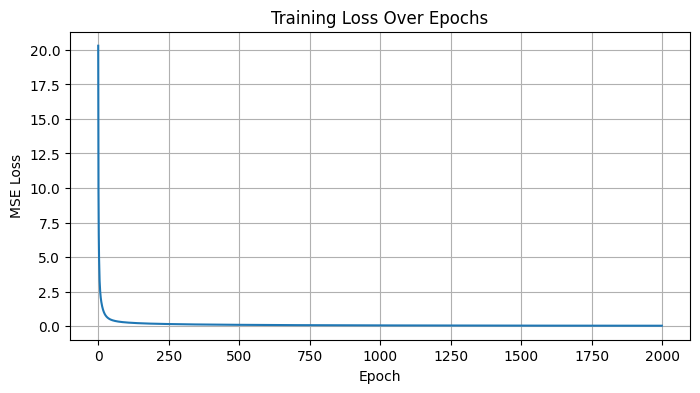

In [23]:
plt.figure(figsize=(8, 4))
plt.plot(loss_history)
plt.title("Training Loss Over Epochs")
plt.xlabel("Epoch")
plt.ylabel("MSE Loss")
plt.grid(True)
plt.show()


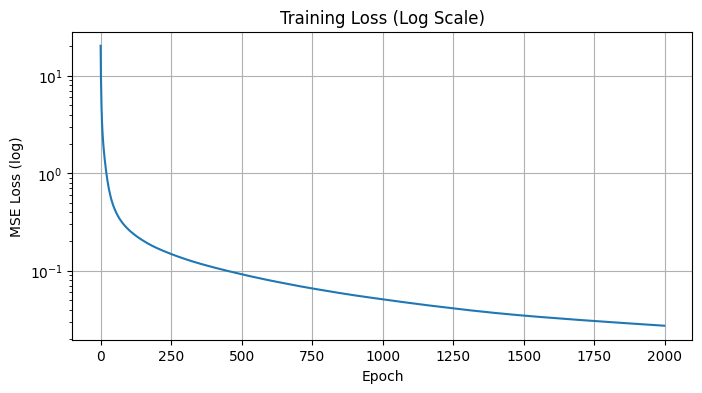

In [24]:
plt.figure(figsize=(8, 4))
plt.semilogy(loss_history)
plt.title("Training Loss (Log Scale)")
plt.xlabel("Epoch")
plt.ylabel("MSE Loss (log)")
plt.grid(True)
plt.show()


 ## STEP 9: Final Prediction on New Data

In [25]:
X_test_np, y_test_np = generate_data(5)
X_test = tf.constant(X_test_np)

y_test_pred = forward_pass(X_test, W1, b1, W2, b2, W3, b3)

print("Predictions on new test data:")
print(y_test_pred.numpy())


Predictions on new test data:
[[0.11531088]
 [0.41311425]
 [0.16388881]
 [0.23704071]
 [0.0323742 ]]
